In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.markers as markers
from mpl_toolkits.mplot3d import Axes3D
import math
import scipy.io as sio
import numpy as np
import os
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from itertools import combinations
from prettytable import PrettyTable


%matplotlib inline

In [2]:
def logistic(x, min_val, max_val, k=1):
    x0 = (min_val+max_val)/2
    return 1/(1 + np.exp(-k*(x-x0)))
#     return np.exp(x0+ k*x)/(1 + np.exp(x0+ k*x))

In [3]:
def heart_data():
    data = pd.read_csv('data/processed.cleveland.data', names=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num'], header=None)
    invalidIndexes = []
    for row in data.itertuples():
        if '?' in row:
            invalidIndexes.append(row[0])
    new_data = data.drop(data.index[invalidIndexes])
    cols = list(new_data.columns)
    new_data[cols] = new_data[cols].astype('float32')
    return new_data

def load_car():
    data = pd.read_csv('data/car.data', header=None)
    cat_columns = data.select_dtypes(['object']).columns
    for c in cat_columns:
        data[c] = data[c].astype('category')
    data[cat_columns] = data[cat_columns].apply(lambda x: x.cat.codes)
    
    cols = list(data.columns)
    
    data = data.groupby(cols[-1]).filter(lambda x: len(x) > 2)
    data[cols[-1]] -= min(data[cols[-1]])
    invalidIndexes = []
    for row in data.itertuples():
        if '?' in row:
            invalidIndexes.append(row[0])
    new_data = data.drop(data.index[invalidIndexes])
    cols = list(new_data.columns)
    new_data[cols] = new_data[cols].astype('float32')
    return new_data

def wine_quality_white():
#     data = pd.read_csv('data/winequality-red.csv', sep=';')
    data = pd.read_csv('data/winequality-white.csv', sep=';')
    cols = list(data.columns)
    data[cols[-1]] -= min(data[cols[-1]])
    invalidIndexes = []
    for row in data.itertuples():
        if '?' in row:
            invalidIndexes.append(row[0])
    new_data = data.drop(data.index[invalidIndexes])
    cols = list(new_data.columns)
    new_data[cols] = new_data[cols].astype('float32')
    return new_data

def wine_quality_red():
    data = pd.read_csv('data/winequality-red.csv', sep=';')
    cols = list(data.columns)
    data[cols[-1]] -= min(data[cols[-1]])
    invalidIndexes = []
    for row in data.itertuples():
        if '?' in row:
            invalidIndexes.append(row[0])
    new_data = data.drop(data.index[invalidIndexes])
    cols = list(new_data.columns)
    new_data[cols] = new_data[cols].astype('float32')
    return new_data

def load_adult():
    data = pd.read_csv('data/adult.data', header=None)
    cat_columns = data.select_dtypes(['object']).columns
    for c in cat_columns:
        data[c] = data[c].astype('category')
    data[cat_columns] = data[cat_columns].apply(lambda x: x.cat.codes)
    invalidIndexes = []
    for row in data.itertuples():
        if '?' in row:
            invalidIndexes.append(row[0])
    new_data = data.drop(data.index[invalidIndexes])
    cols = list(new_data.columns)
    new_data[cols] = new_data[cols].astype('float32')
    return new_data

def load_abalone():
    data = pd.read_csv('data/abalone.data', header=None)
    cat_columns = data.select_dtypes(['object']).columns
    for c in cat_columns:
        data[c] = data[c].astype('category')
    data[cat_columns] = data[cat_columns].apply(lambda x: x.cat.codes)
    
    cols = list(data.columns)
    
    data = data.groupby(cols[-1]).filter(lambda x: len(x) > 2)
    data[cols[-1]] -= min(data[cols[-1]])
    invalidIndexes = []
    for row in data.itertuples():
        if '?' in row:
            invalidIndexes.append(row[0])
    new_data = data.drop(data.index[invalidIndexes])
    cols = list(new_data.columns)
    new_data[cols] = new_data[cols].astype('float32')
    return new_data
    

def load_mat(mat_file):
    data = sio.loadmat(mat_file)
    data = np.concatenate((data['X'], data['Y']-1), axis=1)
#     plt.scatter(data[:300,0], data[:300,1], c='c', marker='x')
#     plt.scatter(data[300:600,0], data[300:600,1], c='b', marker='x')
#     plt.scatter(data[900:1200,0], data[900:1200,1], c='g', marker='x')
#     plt.scatter(data[600:900,0], data[600:900,1], c='r', marker='x')
#     plt.scatter(data[1200:1500,0], data[1200:1500,1], c='y', marker='x')
#     plt.scatter(data[1500:1800,0], data[1500:1800,1], c='m', marker='x')
#     plt.scatter(data[1800:2100,0], data[1800:2100,1], c='k', marker='x')
#     plt.scatter(data[2100:2400,0], data[2100:2400,1], marker='x')
#     plt.show()
    data = pd.DataFrame(data=data)
    return data


In [4]:
#synthetic data
def synthetic_data(p, t, n_dim=2):
    #mean1 = np.concatenate((np.ones(1)*-10,np.ones(12)))
    #mean2 = np.concatenate((np.ones(12),np.ones(1)*10))
    
    q0 = p*t
    q1 = p*(t-q0)
    q2 = p*(t-q0-q1)
    q3 = p*(t-q0-q1-q2)
    q4 = t-q0-q1-q2-q3
    
    q = [np.int(q0), np.int(q1), np.int(q2), np.int(q3), np.int(q4)]
    
#     mean0 = np.ones(n_dim)*1
#     mean1 = np.ones(n_dim)*1.5
#     mean2 = np.ones(n_dim)*1.7
#     mean3 = np.ones(n_dim)*0.5
#     mean4 = np.ones(n_dim)*1.65
    
    
    mean0 = np.random.randint(1,3, size=n_dim)*np.random.rand(n_dim)
    mean1 = np.random.randint(1,3, size=n_dim)*np.random.rand(n_dim)
    mean2 = np.random.randint(1,3, size=n_dim)*np.random.rand(n_dim)
    mean3 = np.random.randint(1,3, size=n_dim)*np.random.rand(n_dim)
    mean4 = np.random.randint(1,3, size=n_dim)*np.random.rand(n_dim)
    
    
#     np.random.seed(1234)
    
    var0 = np.diag(np.random.randint(1,10, size=n_dim)*np.random.rand(n_dim))
    var1 = np.diag(np.random.randint(1,10, size=n_dim)*np.random.rand(n_dim))
    var2 = np.diag(np.random.randint(1,10, size=n_dim)*np.random.rand(n_dim))
    var3 = np.diag(np.random.randint(1,10, size=n_dim)*np.random.rand(n_dim))
    var4 = np.diag(np.random.randint(1,10, size=n_dim)*np.random.rand(n_dim))
    
    #g0 = np.random.multivariate_normal(mean0, np.eye(13), size=q[0])
    #g1 = np.random.multivariate_normal(mean1, np.eye(13), size=q[1])
    #g2 = np.random.multivariate_normal(mean2, np.eye(13), size=q[2])
    #g3 = np.random.multivariate_normal(mean3, np.eye(13), size=q[3])
    #g4 = np.random.multivariate_normal(mean4, np.eye(13), size=q[4])
    
    g0 = np.random.multivariate_normal(mean0, var0, size=q[0])
    g1 = np.random.multivariate_normal(mean1, var1, size=q[1])
    g2 = np.random.multivariate_normal(mean2, var2, size=q[2])
    g3 = np.random.multivariate_normal(mean3, var3, size=q[3])
    g4 = np.random.multivariate_normal(mean4, var4, size=q[4])

    
    y0 = np.asarray([0]*q[0]).reshape(q[0],1)
    y1 = np.asarray([1]*q[1]).reshape(q[1],1)
    y2 = np.asarray([2]*q[2]).reshape(q[2],1)
    y3 = np.asarray([3]*q[3]).reshape(q[3],1)
    y4 = np.asarray([4]*q[4]).reshape(q[4],1)


    #y1 = np.random.choice(5, 297, p=[0.54, 0.18, 0.12, 0.12, 0.04]).reshape(297,1)
    #y2 = np.random.choice(5, 297, p=[0.54, 0.18, 0.12, 0.12, 0.04]).reshape(297,1)
    #y3 = np.random.choice(5, 297, p=[0.54, 0.18, 0.12, 0.12, 0.04]).reshape(297,1)
    #y4 = np.random.choice(5, 297, p=[0.54, 0.18, 0.12, 0.12, 0.04]).reshape(297,1)
    
    g0 = np.concatenate((g0,y0), axis=1)
    g1 = np.concatenate((g1,y1), axis=1)
    g2 = np.concatenate((g2,y2), axis=1)
    g3 = np.concatenate((g3,y3), axis=1)
    g4 = np.concatenate((g4,y4), axis=1)

    g = np.concatenate([g0,g1,g2,g3,g4], axis=0)
    d = pd.DataFrame(data=g)

#     d = pd.DataFrame(data=g, columns=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num'])
    if n_dim == 2:
        plt.scatter(g0[:,0], g0[:,1], c='c')
        plt.scatter(g1[:,0], g1[:,1], c='b')
        plt.scatter(g2[:,0], g2[:,1], c='r')
        plt.scatter(g3[:,0], g3[:,1], c='g')
        plt.scatter(g4[:,0], g4[:,1], c='y')
        plt.show()
    elif n_dim == 3:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(g0[:,0], g0[:,1], g0[:,2], c='c')
        ax.scatter(g1[:,0], g1[:,1], g1[:,2], c='b')
        ax.scatter(g2[:,0], g2[:,1], g2[:,2], c='r')
        ax.scatter(g3[:,0], g3[:,1], g3[:,2], c='g')
        ax.scatter(g4[:,0], g4[:,1], g4[:,2], c='y')
        plt.show()
    
    return d

#d1 = pd.DataFrame(data=g1, columns=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num'])
#d2 = pd.DataFrame(data=g2, columns=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num'])
#d3 = pd.DataFrame(data=g3, columns=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num'])
#d4 = pd.DataFrame(data=g4, columns=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num'])


In [5]:
#optimal cutpoints

#find the closest point to (0,1) coordinate
def roc01(fpr, tpr):
    tl = [0,1]
    index = None
    opt = np.inf
    for i in range(len(fpr)):
        d = np.linalg.norm(np.array(tl) - np.array([fpr[i], tpr[i]]))
        if d < opt:
            opt = d
            index = i
    return fpr[index], tpr[index]

#Youden's index
def youden_index(fpr, tpr):
    sp = 1-fpr
    se = tpr
    index = None
    opt = -1
    for i in range(len(fpr)):
        pt = sp[i]+se[i]-1
        if pt > opt:
            opt = pt
            index = i
            
    return fpr[index], tpr[index]
    
#maximize sensitivity
def max_se(fpr, tpr, threshold=1e-4):
    sp = 1-fpr
    se = tpr
    index = None
    opt_se = -1
    opt_sp = -1
    for i in range(len(fpr)):
        if se[i] > opt_se:
            opt_se = se[i]
            opt_sp = sp[i]
            index = i
        elif abs(se[i]-opt_se) <= threshold:
            if sp[i] > opt_sp:
                opt_se = se[i]
                opt_sp = sp[i]
                index = i
    return fpr[index], tpr[index]

#maximize specificity
def max_sp(fpr, tpr, threshold=1e-4):
    sp = 1-fpr
    se = tpr
    index = None
    opt_se = -1
    opt_sp = -1
    for i in range(len(fpr)):
        if np.isclose(fpr[i],0.0):
            continue
        if sp[i] > opt_sp:
            opt_se = se[i]
            opt_sp = sp[i]
            index = i
        elif abs(sp[i]-opt_sp) <= threshold:
            if se[i] > opt_se:
                opt_se = se[i]
                opt_sp = sp[i]
                index = i
    return fpr[index], tpr[index]
                
## https://en.wikipedia.org/wiki/Diagnostic_odds_ratio
def max_dor(fpr, tpr):
    sp = 1-fpr
    se = tpr
    index = None
    opt_dor = -1
    for i in range(len(fpr)):
        dor = (se[i]/(1.0-se[i]))*(sp[i]/(1.0-sp[i]))
        if dor > opt_dor and not np.isinf(dor) and not np.isnan(dor):
            opt_dor = dor
            index = i
    return fpr[index], tpr[index]


In [6]:
class ClassifierWithRoc(object):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.n_classes = len(np.unique(Y))
        self.n_clf = self.n_classes * (self.n_classes - 1) // 2
        self.c_groups = [(t[1],t[0]) for t in list(combinations(list(range(0,self.n_classes)),2))]
    
    def split_data(self, X, Y, min_samples=500):
        if X.shape[0] >= min_samples:
            x_train, x_test_and_val, y_train, y_test_and_val = train_test_split(X, Y, test_size=.40, stratify=Y)
            x_val, x_test, y_val, y_test = train_test_split(x_test_and_val, y_test_and_val, 
                                                            test_size=.50, stratify=y_test_and_val)
        else:
            x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.20, stratify=Y)
            x_val = None; y_val = None
            
        return x_train, x_val, x_test, y_train, y_val, y_test
    
    def z_score(self, x_train):      
        scaler = preprocessing.StandardScaler().fit(x_train)
        return scaler
    
    def estimator(self, x_train, y_train, scaler):
        x_train = scaler.transform(x_train)
        ovo = OneVsOneClassifier(SVC(kernel='linear', probability=True, class_weight='balanced'), n_jobs=-1)
        ovo.fit(x_train, y_train)
        return ovo
    
    def predict(self, estimator, x_test, y_test, scaler, points=None, c=0, mode='half', clfs=None):
        modes = {'zero': 0, 'half': 0.5, 'one':1}
        x_test = scaler.transform(x_test)
        if points is None:
            y_test_bin = label_binarize(y_test, classes=list(range(self.n_classes)))
            votes = np.zeros(y_test_bin.shape)
#             pred = estimator.predict(x_test)
            if clfs is None:
                for i in range(self.n_clf):
                    clf = estimator.estimators_[i]
                    proba = clf.decision_function(x_test)
                    for j, p in enumerate(proba):
                        if p > 0:
                            votes[j, self.c_groups[i][0]] += 1
                        else:
                            votes[j, self.c_groups[i][1]] += 1
            else:
                for i in clfs:
                    clf = estimator.estimators_[i]
                    proba = clf.decision_function(x_test)
                    for j, p in enumerate(proba):
                        if p > 0:
                            votes[j, self.c_groups[i][0]] += 1
                        else:
                            votes[j, self.c_groups[i][1]] += 1
#             cm = confusion_matrix(y_test, pred)
#             acc = cm.diagonal().sum() / cm.sum()
#             return [pred, cm, acc]
        elif c < 2:
            y_test_bin = label_binarize(y_test, classes=list(range(self.n_classes)))
            votes = np.zeros(y_test_bin.shape)
            if clfs is None:
                for i in range(self.n_clf):
                    clf = estimator.estimators_[i]
                    proba = clf.decision_function(x_test)
                    for j, p in enumerate(proba):
                        if p > points[i][c] or np.isclose(p,points[i][c]):
                            votes[j, self.c_groups[i][0]] += 1
                        else:
                            votes[j, self.c_groups[i][1]] += 1
            else:
                for i in clfs:
                    clf = estimator.estimators_[i]
                    proba = clf.decision_function(x_test)
                    for j, p in enumerate(proba):
                        if p > points[i][c] or np.isclose(p,points[i][c]):
                            votes[j, self.c_groups[i][0]] += 1
                        else:
                            votes[j, self.c_groups[i][1]] += 1
        elif c == 2:
            if mode != 'logistic':
                y_test_bin = label_binarize(y_test, classes=list(range(self.n_classes)))
                votes = np.zeros(y_test_bin.shape)
                if clfs is None:
                    for i in range(self.n_clf):
                        clf = estimator.estimators_[i]
                        proba = clf.decision_function(x_test)
                        for j, p in enumerate(proba):
                            if p > points[i].max() or np.isclose(p, points[i].max()):
                                votes[j, self.c_groups[i][0]] += 1
                            elif p > points[i].min() and p < points[i].max():
                                votes[j, self.c_groups[i][0]] += modes[mode]
                                votes[j, self.c_groups[i][1]] += modes[mode]
                            elif p < points[i].min():
                                votes[j, self.c_groups[i][1]] += 1
                else:
                    for i in clfs:
                        clf = estimator.estimators_[i]
                        proba = clf.decision_function(x_test)
                        for j, p in enumerate(proba):
                            if p > points[i].max() or np.isclose(p, points[i].max()):
                                votes[j, self.c_groups[i][0]] += 1
                            elif p > points[i].min() and p < points[i].max():
                                votes[j, self.c_groups[i][0]] += modes[mode]
                                votes[j, self.c_groups[i][1]] += modes[mode]
                            elif p < points[i].min():
                                votes[j, self.c_groups[i][1]] += 1
            else:
                y_test_bin = label_binarize(y_test, classes=list(range(self.n_classes)))
                votes = np.zeros(y_test_bin.shape)
                if clfs is None:
                    for i in range(self.n_clf):
                        clf = estimator.estimators_[i]
                        proba = clf.decision_function(x_test)
                        for j, p in enumerate(proba):
                            if p > points[i].max() or np.isclose(p, points[i].max()):
                                votes[j, self.c_groups[i][0]] += 1
                            elif p > points[i].min() and p < points[i].max():
                                #adjust steepness to interval
                                #12 seeems to be a good number
                                k = 12 / (abs(max(points[i]) - min(points[i])))
                                point = logistic(p, min(points[i]), max(points[i]), k=k)
                                votes[j, self.c_groups[i][0]] += point
                                votes[j, self.c_groups[i][1]] += 1-point
                            elif p < points[i].min():
                                votes[j, self.c_groups[i][1]] += 1
                else:
                    for i in clfs:
                        clf = estimator.estimators_[i]
                        proba = clf.decision_function(x_test)
                        for j, p in enumerate(proba):
                            if p > points[i].max() or np.isclose(p, points[i].max()):
                                votes[j, self.c_groups[i][0]] += 1
                            elif p > points[i].min() and p < points[i].max():
                                #adjust steepness to interval
                                #12 seeems to be a good number
                                k = 12 / (abs(max(points[i]) - min(points[i])))
                                point = logistic(p, min(points[i]), max(points[i]), k=k)
                                votes[j, self.c_groups[i][0]] += point
                                votes[j, self.c_groups[i][1]] += 1-point
                            elif p < points[i].min():
                                votes[j, self.c_groups[i][1]] += 1
        
#         print(votes)
        occurrences = np.asarray([np.where(t==t.max())[0] for t in votes])
#         print(occurrences)
        pred = [p[-1] for p in occurrences]
        cm = confusion_matrix(y_test, pred)
        acc = cm.diagonal().sum() / cm.sum()
        return [pred, cm, acc]
        
        
    def calculate_roc(self, estimator, x_val, x_train, y_val, y_train, scaler):
        clf_index = 0
        fpr = dict(); tpr = dict(); thresholds = dict(); roc_auc = dict(); cutpoints = dict()
        x_val = scaler.transform(x_val) if x_val is not None else None
        x_train = scaler.transform(x_train)
        y_val_bin = label_binarize(y_val, classes=list(range(self.n_classes))) if y_val is not None else None
        y_train_bin = label_binarize(y_train, classes=list(range(self.n_classes)))
        for i in range(self.n_classes):
            for j in range(self.n_classes):
                if j > i:
                    clf = estimator.estimators_[clf_index]
                    if y_val_bin is not None and x_val is not None:
                        proba = clf.decision_function(x_val)
                        fpr[clf_index], tpr[clf_index], thresholds[clf_index] = roc_curve(abs(y_val_bin[:, i]-1),
                                                                                          proba)
                    else:
                        proba = clf.decision_function(x_train)
                        fpr[clf_index], tpr[clf_index], thresholds[clf_index] = roc_curve(abs(y_train_bin[:, i]-1),
                                                                                          proba)
                    roc_auc[clf_index] = auc(fpr[clf_index], tpr[clf_index])
                    youden_cut = youden_index(fpr[clf_index], tpr[clf_index])
                    maxdor_cut = max_dor(fpr[clf_index], tpr[clf_index])
                    y_index = np.where(np.isclose(fpr[clf_index],youden_cut[0]))[0][0]
                    d_index = np.where(np.isclose(fpr[clf_index],maxdor_cut[0]))[0][0]
                    if y_index == 0:
                        y_index += 1
                    if d_index == 0:
                        d_index += 1

                    cutpoints[clf_index] = np.array([thresholds[clf_index][y_index], thresholds[clf_index][d_index]])
                    clf_index += 1
        return fpr, tpr, thresholds, roc_auc, cutpoints
    
    def plot_roc(self, fpr, tpr, thresholds, roc_auc, cutpoints, show=True, save=False, clfs=None):
        range_clf = list(range(self.n_clf)) if clfs is None else clfs
        for i in range_clf:
            youden_cut = youden_index(fpr[i], tpr[i])
            maxdor_cut = max_dor(fpr[i], tpr[i])
            default = np.where(np.isclose(thresholds[i],min(thresholds[i], key=abs)))[0][0]
            fig, ax = plt.subplots(1,2, figsize=(15,7))
            lw = 2
            ax[0].plot(fpr[i], tpr[i], color='darkorange',
                     lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i], zorder=-1)
            ax[0].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', zorder=-1)
            ax[0].set_xlim([-0.05, 1.05])
            ax[0].set_ylim([-0.05, 1.05])
            ax[0].set_xlabel('False Positive Rate')
            ax[0].set_ylabel('True Positive Rate')
            ax[0].set_title('Receiver operating characteristic for class ' + str(tuple(reversed(self.c_groups[i]))))
            #ax.scatter(opt_cutpoint1[0], opt_cutpoint1[1], c='g', zorder=1, label='MaxSp cutpoint', s=50)
            #ax.scatter(opt_cutpoint2[0], opt_cutpoint2[1], c='r', zorder=1, label='MaxSe cutpoint', s=50)
            ax[0].scatter(youden_cut[0], youden_cut[1], c='b', zorder=1, label='Youden', s=50)
            ax[0].scatter(maxdor_cut[0], maxdor_cut[1], c='r', zorder=1, label='Max Dor', s=50)
            ax[0].scatter(fpr[i][default], tpr[i][default], c='g', zorder=1, label='Default', s=50)
            ax[0].legend(loc="lower right")

            ax2 = ax[0].twinx()
            ax2.plot(fpr[i], thresholds[i], color='r', lw=lw, linestyle='--', zorder=-1)
            ax2.set_ylabel('Threshold',color='r')
            ax2.set_ylim([thresholds[i][-1],thresholds[i][0]])
            ax2.set_xlim([-0.05, 1.05])

            if np.isclose(min(cutpoints[i]), max(cutpoints[i])):  
                ax[1].axis('off')
            else:
                #adjust steepness to interval
                #12 seeems to be a good number
                k = 12 / (abs(max(cutpoints[i]) - min(cutpoints[i])))

                x_range = np.arange(min(cutpoints[i]), max(cutpoints[i]), 0.0001)
                y_range = logistic(x_range, min(cutpoints[i]), max(cutpoints[i]), k=k)
                ax[1].set_title('Logistic function between cutpoints')

                ax[1].spines['left'].set_position('center')
                ax[1].spines['right'].set_color('none')
                ax[1].spines['top'].set_color('none')
                ax[1].xaxis.set_ticks_position('bottom')
                ax[1].yaxis.set_ticks_position('left')
                ax[1].plot(x_range, y_range, c='y', lw=lw, zorder=-1)
                ax[1].scatter(cutpoints[i][0], logistic(cutpoints[i][0], min(cutpoints[i]), max(cutpoints[i]), k=k), 
                              c='b', zorder=1, label='Youden', s=50)
                ax[1].scatter(cutpoints[i][1], logistic(cutpoints[i][1], min(cutpoints[i]), max(cutpoints[i]), k=k),
                              c='r', zorder=1, label='Max Dor', s=50)

                ax[1].plot([x_range[0], x_range[0]], [-0.05, y_range[0]], linestyle='--', c='k')
                ax[1].plot([x_range[-1], x_range[-1]], [-0.05, y_range[-1]], linestyle='--', c='k')
                ax[1].set_xticks(cutpoints[i], minor=False)

            
            fig.subplots_adjust(hspace=0.3, wspace=0.6, top=0.8)
            if save:
                plots_folder = os.path.join(os.getcwd(),'roc_plots')
                if not os.path.exists(plots_folder):
                    os.mkdir(plots_folder)
                plt.savefig(os.path.join(os.getcwd(), 'heart_' + str(tuple(reversed(self.c_groups[i])))) + '.png',
                            bbox_inches='tight', pad_inches=0.5)
            if show:
                plt.show()
        
        
        

In [7]:
def apply(data, times=1, clfs=None):
    cols = list(data.columns)
    Y = data[cols[-1]].copy()
    cols.remove(cols[-1])
    X = data[cols].copy()
    roc_clf = ClassifierWithRoc(X,Y)
    
    pred = []; pred_y = []; pred_dor = []; pred_zero = []; pred_half = []; pred_one = []; pred_log = []
    
    for i in tqdm(range(times)):
        x_train, x_val, x_test, y_train, y_val, y_test = roc_clf.split_data(X, Y)
        scaler = roc_clf.z_score(x_train)
        est = roc_clf.estimator(x_train, y_train, scaler)
        fpr, tpr, thresholds, roc_auc, cutpoints = roc_clf.calculate_roc(est, x_val, x_train, y_val, 
                                                                         y_train, scaler)
        pred.append(roc_clf.predict(est, x_test, y_test, scaler, clfs=clfs))
        pred_y.append(roc_clf.predict(est, x_test, y_test, scaler, cutpoints, c=0, clfs=clfs))
        pred_dor.append(roc_clf.predict(est, x_test, y_test, scaler, cutpoints, c=1, clfs=clfs))
        pred_zero.append(roc_clf.predict(est, x_test, y_test, scaler, cutpoints, c=2, mode='zero', clfs=clfs))
        pred_half.append(roc_clf.predict(est, x_test, y_test, scaler, cutpoints, c=2, mode='half', clfs=clfs))
        pred_one.append(roc_clf.predict(est, x_test, y_test, scaler, cutpoints, c=2, mode='one', clfs=clfs))
        pred_log.append(roc_clf.predict(est, x_test, y_test, scaler, cutpoints, c=2, mode='logistic', clfs=clfs))
#         roc_clf.plot_roc(fpr, tpr, thresholds, roc_auc, cutpoints)
    
    pred = np.asarray(pred); pred_y = np.asarray(pred_y); pred_dor = np.asarray(pred_dor); 
    pred_zero = np.asarray(pred_zero); pred_half = np.asarray(pred_half); pred_one = np.asarray(pred_one); 
    pred_log = np.asarray(pred_log)
    
    return np.array([[np.mean(pred[:,2]), np.std(pred[:,2])], [np.mean(pred_y[:,2]), np.std(pred_y[:,2])], [np.mean(pred_dor[:,2]), np.std(pred_dor[:,2])],
            [np.mean(pred_zero[:,2]), np.std(pred_zero[:,2])], [np.mean(pred_half[:,2]), np.std(pred_half[:,2])], 
            [np.mean(pred_one[:,2]), np.std(pred_one[:,2])], [np.mean(pred_log[:,2]), np.std(pred_log[:,2])]])

#     print(np.mean(pred[:,2]))
#     print(np.mean(pred_y[:,2]))
#     print(np.mean(pred_dor[:,2]))
#     print(np.mean(pred_zero[:,2]))
#     print(np.mean(pred_half[:,2]))
#     print(np.mean(pred_one[:,2]))
#     print(np.mean(pred_log[:,2]))

In [54]:
def apply_with_selection(data, name, times=1):
    acc_clf_pred = []; acc_clf_pred_y = []; acc_clf_pred_dor = []; acc_clf_pred_zero = []; acc_clf_pred_half = [];
    acc_clf_pred_one = []; acc_clf_pred_log = []

    acc_all_pred = []; acc_all_pred_y = []; acc_all_pred_dor = []; acc_all_pred_zero = []; acc_all_pred_half = [];
    acc_all_pred_one = []; acc_all_pred_log = []

    cols = list(data.columns)

    classes = np.unique(data.loc[:,cols[-1]])
    print(classes)
    classes_data = []
    for c in classes:
        classes_data.append(data.iloc[np.where(data.loc[:,cols[-1]] == c)])
    centroids = []
    for cd in classes_data:
        centroids.append(np.mean(cd, axis=0)[:-1])

    Y = data.iloc[:,-1]
    X = data.iloc[:,:-1]
    roc_clf = ClassifierWithRoc(X,Y)
    
    for t in tqdm(range(times)):
        #data = load_mat('data/synth8.mat')
        x_train, x_val, x_test, y_train, y_val, y_test = roc_clf.split_data(X, Y)
        scaler = roc_clf.z_score(x_train)
        est = roc_clf.estimator(x_train, y_train, scaler)
        fpr, tpr, thresholds, roc_auc, cutpoints = roc_clf.calculate_roc(est, x_val, x_train, y_val, 
                                                                         y_train, scaler)

        #calculate distances
        distances = []
        for i, pt in x_test.iterrows():
            dist = []
            for j, c in enumerate(centroids):
                d = np.linalg.norm(pt-c)
                dist.append([d, j])
            dist.sort()
            distances.append(dist)

        distances = np.asarray(distances)
        
        c_distances = []

        for dist in distances:
            c_dist = []
            for i, d in enumerate(dist):
                if i == 0:
                    c_dist.append([0.0, d[1]])
                    continue
                else:
                    c_dist.append([d[0]-dist[0,0], d[1]])
            c_distances.append(c_dist)

        c_distances = np.asarray(c_distances)

        influences = []
        for dist in c_distances:
            std = np.std(dist[:,0])
            influences.append(list(dist[np.where(dist[:,0] < std)[0]][:,1].astype(np.int32)))

        influences = np.asarray(influences)
#         print(influences)

        t_1 = PrettyTable(['point', 'original', 'default', 'youden', 'max dor', 'both zero', 'both half', 'both one', 'both logistic'])

        clf_pred = []; clf_pred_y = []; clf_pred_dor = []; clf_pred_zero = []; clf_pred_half = []; clf_pred_one = []; 
        clf_pred_log = []

        for i, inf in enumerate(influences):
            if len(inf) == 1:
                clf_pred.append(inf[0]); clf_pred_y.append(inf[0]); clf_pred_dor.append(inf[0]); 
                clf_pred_zero.append(inf[0]); clf_pred_half.append(inf[0]); 
                clf_pred_one.append(inf[0]); clf_pred_log.append(inf[0]);
                
                t_1.add_row([i, y_test.iloc[i], inf[0], inf[0], inf[0], inf[0], 
                             inf[0], inf[0], inf[0]])
                continue
                
            pairs = [pair for pair in roc_clf.c_groups if pair[0] in inf and pair[1] in inf]
            clfs = [roc_clf.c_groups.index(clf) for clf in pairs]
            pred = roc_clf.predict(est, np.array([x_test.iloc[i]]), np.array([y_test.iloc[i]]), scaler, clfs=clfs)
            pred_y = roc_clf.predict(est, np.array([x_test.iloc[i]]), np.array([y_test.iloc[i]]), scaler, cutpoints, c=0, clfs=clfs)
            pred_dor = roc_clf.predict(est, np.array([x_test.iloc[i]]), np.array([y_test.iloc[i]]), scaler, cutpoints, c=1, clfs=clfs)
            pred_zero = roc_clf.predict(est, np.array([x_test.iloc[i]]), np.array([y_test.iloc[i]]), scaler, cutpoints, c=2, mode='zero', clfs=clfs)
            pred_half = roc_clf.predict(est, np.array([x_test.iloc[i]]), np.array([y_test.iloc[i]]), scaler, cutpoints, c=2, mode='half', clfs=clfs)
            pred_one = roc_clf.predict(est, np.array([x_test.iloc[i]]), np.array([y_test.iloc[i]]), scaler, cutpoints, c=2, mode='one', clfs=clfs)
            pred_log = roc_clf.predict(est, np.array([x_test.iloc[i]]), np.array([y_test.iloc[i]]), scaler, cutpoints, c=2, mode='logistic', clfs=clfs)

            clf_pred.append(pred[0][0]); clf_pred_y.append(pred_y[0][0]); clf_pred_dor.append(pred_dor[0][0]); 
            clf_pred_zero.append(pred_zero[0][0]); clf_pred_half.append(pred_half[0][0]); 
            clf_pred_one.append(pred_one[0][0]); clf_pred_log.append(pred_log[0][0]);

            t_1.add_row([i, y_test.iloc[i], pred[0][0], pred_y[0][0], pred_dor[0][0], pred_zero[0][0], 
                         pred_half[0][0], pred_one[0][0], pred_log[0][0]])    
        #     print(20*"#" + " Point " + str(i) + " " + 20*"#")
        #     roc_clf.plot_roc(fpr, tpr, thresholds, roc_auc, cutpoints, clfs=clfs)
            # print(t_1)

        t_2 = PrettyTable(['point', 'original', 'default', 'youden', 'max dor', 'both zero', 'both half', 'both one', 'both logistic'])

        all_pred = []; all_pred_y = []; all_pred_dor = []; all_pred_zero = []; all_pred_half = []; all_pred_one = []; 
        all_pred_log = []

        for i, (_, p) in enumerate(x_test.iterrows()):
            pred = roc_clf.predict(est, np.array([p]), np.array([y_test.iloc[i]]), scaler)
            pred_y = roc_clf.predict(est, np.array([p]), np.array([y_test.iloc[i]]), scaler, cutpoints, c=0)
            pred_dor = roc_clf.predict(est, np.array([p]), np.array([y_test.iloc[i]]), scaler, cutpoints, c=1)
            pred_zero = roc_clf.predict(est, np.array([p]), np.array([y_test.iloc[i]]), scaler, cutpoints, c=2, mode='zero')
            pred_half = roc_clf.predict(est, np.array([p]), np.array([y_test.iloc[i]]), scaler, cutpoints, c=2, mode='half')
            pred_one = roc_clf.predict(est, np.array([p]), np.array([y_test.iloc[i]]), scaler, cutpoints, c=2, mode='one')
            pred_log = roc_clf.predict(est, np.array([p]), np.array([y_test.iloc[i]]), scaler, cutpoints, c=2, mode='logistic')

            all_pred.append(pred[0][0]); all_pred_y.append(pred_y[0][0]); all_pred_dor.append(pred_dor[0][0]); 
            all_pred_zero.append(pred_zero[0][0]); all_pred_half.append(pred_half[0][0]); 
            all_pred_one.append(pred_one[0][0]); all_pred_log.append(pred_log[0][0]);

            t_2.add_row([i, y_test.iloc[i], pred[0][0], pred_y[0][0], pred_dor[0][0], pred_zero[0][0], 
                         pred_half[0][0], pred_one[0][0], pred_log[0][0]])   
    
    
        acc_clf_pred.append(accuracy_score(np.asarray(y_test), clf_pred)); 
        acc_clf_pred_y.append(accuracy_score(np.asarray(y_test), clf_pred_y)); 
        acc_clf_pred_dor.append(accuracy_score(np.asarray(y_test), clf_pred_dor)); 
        acc_clf_pred_zero.append(accuracy_score(np.asarray(y_test), clf_pred_zero)); 
        acc_clf_pred_half.append(accuracy_score(np.asarray(y_test), clf_pred_half)); 
        acc_clf_pred_one.append(accuracy_score(np.asarray(y_test), clf_pred_one)); 
        acc_clf_pred_log.append(accuracy_score(np.asarray(y_test), clf_pred_log))

        acc_all_pred.append(accuracy_score(np.asarray(y_test), all_pred)); 
        acc_all_pred_y.append(accuracy_score(np.asarray(y_test), all_pred_y)); 
        acc_all_pred_dor.append(accuracy_score(np.asarray(y_test), all_pred_dor)); 
        acc_all_pred_zero.append(accuracy_score(np.asarray(y_test), all_pred_zero)); 
        acc_all_pred_half.append(accuracy_score(np.asarray(y_test), all_pred_half)); 
        acc_all_pred_one.append(accuracy_score(np.asarray(y_test), all_pred_one)); 
        acc_all_pred_log.append(accuracy_score(np.asarray(y_test), all_pred_log))

        
    t_3 = PrettyTable()
    t_3.title = name
    print(name)
    
    t_3.add_column('Method', ['Default cut',
                              'Youden', 
                              'Max DOR',
                              'Zero on doubt',  
                              'Half on doubt', 
                              'One on doubt', 
                              'Logistic on doubt'])
    
    t_3.add_column('With all clf', [str(np.around([np.mean(acc_all_pred)], decimals=2)[0]) + ' +/- ' + 
                                    str(np.around([np.std(acc_all_pred)], decimals=2)[0]),
                                    str(np.around([np.mean(acc_all_pred_y)], decimals=2)[0]) + ' +/- ' + 
                                    str(np.around([np.std(acc_all_pred_y)], decimals=2)[0]), 
                                    str(np.around([np.mean(acc_all_pred_dor)], decimals=2)[0]) + ' +/- ' + 
                                    str(np.around([np.std(acc_all_pred_dor)], decimals=2)[0]), 
                                    str(np.around([np.mean(acc_all_pred_zero)], decimals=2)[0]) + ' +/- ' + 
                                    str(np.around([np.std(acc_all_pred_zero)], decimals=2)[0]), 
                                    str(np.around([np.mean(acc_all_pred_half)], decimals=2)[0]) + ' +/- ' + 
                                    str(np.around([np.std(acc_all_pred_half)], decimals=2)[0]), 
                                    str(np.around([np.mean(acc_all_pred_one)], decimals=2)[0]) + ' +/- ' + 
                                    str(np.around([np.std(acc_all_pred_one)], decimals=2)[0]),  
                                    str(np.around([np.mean(acc_all_pred_log)], decimals=2)[0]) + ' +/- ' + 
                                    str(np.around([np.std(acc_all_pred_log)], decimals=2)[0])])


    t_3.add_column('With filtered clf', [str(np.around([np.mean(acc_clf_pred)], decimals=2)[0]) + ' +/- ' + 
                                         str(np.around([np.std(acc_clf_pred)], decimals=2)[0]),
                                         str(np.around([np.mean(acc_clf_pred_y)], decimals=2)[0]) + ' +/- ' + 
                                         str(np.around([np.std(acc_clf_pred_y)], decimals=2)[0]), 
                                         str(np.around([np.mean(acc_clf_pred_dor)], decimals=2)[0]) + ' +/- ' + 
                                         str(np.around([np.std(acc_clf_pred_dor)], decimals=2)[0]), 
                                         str(np.around([np.mean(acc_clf_pred_zero)], decimals=2)[0]) + ' +/- ' + 
                                         str(np.around([np.std(acc_clf_pred_zero)], decimals=2)[0]), 
                                         str(np.around([np.mean(acc_clf_pred_half)], decimals=2)[0]) + ' +/- ' + 
                                         str(np.around([np.std(acc_clf_pred_half)], decimals=2)[0]), 
                                         str(np.around([np.mean(acc_clf_pred_one)], decimals=2)[0]) + ' +/- ' + 
                                         str(np.around([np.std(acc_clf_pred_one)], decimals=2)[0]),  
                                         str(np.around([np.mean(acc_clf_pred_log)], decimals=2)[0]) + ' +/- ' + 
                                         str(np.around([np.std(acc_clf_pred_log)], decimals=2)[0])])
    
    print(t_3)
    t_3.format = True
    return t_3.get_html_string()
                                        

In [55]:
datasets = [heart_data(), load_car(), wine_quality_red(), wine_quality_white(), load_abalone(), 
            load_mat('data/synth8.mat'), load_mat('data/synth8_unbalanced.mat')]
names = ['heart', 'car', 'red wine quality', 'white wine quality', 'abalone', 'synth8',
         'unbalanced synth8']
tables = []
for i, d in enumerate(datasets):
    tables.append(apply_with_selection(d, names[i], times=1))
# apply_with_selection(datasets[0], names[0], times=2)
# apply_with_selection(datasets[1], times=20)

  0%|          | 0/1 [00:00<?, ?it/s]

[ 0.  1.  2.  3.  4.]


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/1 [00:00<?, ?it/s]

heart
+-------------------+--------------+-------------------+
|       Method      | With all clf | With filtered clf |
+-------------------+--------------+-------------------+
|    Default cut    | 0.47 +/- 0.0 |    0.55 +/- 0.0   |
|       Youden      | 0.53 +/- 0.0 |    0.63 +/- 0.0   |
|      Max DOR      | 0.38 +/- 0.0 |    0.45 +/- 0.0   |
|   Zero on doubt   | 0.35 +/- 0.0 |    0.45 +/- 0.0   |
|   Half on doubt   | 0.35 +/- 0.0 |    0.48 +/- 0.0   |
|    One on doubt   | 0.37 +/- 0.0 |    0.48 +/- 0.0   |
| Logistic on doubt | 0.45 +/- 0.0 |    0.55 +/- 0.0   |
+-------------------+--------------+-------------------+
[ 0.  1.  2.  3.]


  0%|          | 0/1 [00:00<?, ?it/s]

car
+-------------------+--------------+-------------------+
|       Method      | With all clf | With filtered clf |
+-------------------+--------------+-------------------+
|    Default cut    | 0.52 +/- 0.0 |    0.51 +/- 0.0   |
|       Youden      | 0.51 +/- 0.0 |    0.49 +/- 0.0   |
|      Max DOR      | 0.37 +/- 0.0 |    0.45 +/- 0.0   |
|   Zero on doubt   | 0.45 +/- 0.0 |    0.45 +/- 0.0   |
|   Half on doubt   | 0.45 +/- 0.0 |    0.45 +/- 0.0   |
|    One on doubt   | 0.42 +/- 0.0 |    0.45 +/- 0.0   |
| Logistic on doubt | 0.48 +/- 0.0 |    0.46 +/- 0.0   |
+-------------------+--------------+-------------------+
[ 0.  1.  2.  3.  4.  5.]


  0%|          | 0/1 [00:00<?, ?it/s]

red wine quality
+-------------------+--------------+-------------------+
|       Method      | With all clf | With filtered clf |
+-------------------+--------------+-------------------+
|    Default cut    | 0.38 +/- 0.0 |    0.35 +/- 0.0   |
|       Youden      | 0.02 +/- 0.0 |    0.31 +/- 0.0   |
|      Max DOR      | 0.26 +/- 0.0 |    0.36 +/- 0.0   |
|   Zero on doubt   | 0.26 +/- 0.0 |    0.36 +/- 0.0   |
|   Half on doubt   | 0.27 +/- 0.0 |    0.39 +/- 0.0   |
|    One on doubt   | 0.23 +/- 0.0 |    0.38 +/- 0.0   |
| Logistic on doubt | 0.12 +/- 0.0 |    0.34 +/- 0.0   |
+-------------------+--------------+-------------------+
[ 0.  1.  2.  3.  4.  5.  6.]


  0%|          | 0/1 [00:00<?, ?it/s]

white wine quality
+-------------------+--------------+-------------------+
|       Method      | With all clf | With filtered clf |
+-------------------+--------------+-------------------+
|    Default cut    | 0.35 +/- 0.0 |    0.26 +/- 0.0   |
|       Youden      | 0.24 +/- 0.0 |    0.26 +/- 0.0   |
|      Max DOR      | 0.29 +/- 0.0 |    0.23 +/- 0.0   |
|   Zero on doubt   | 0.3 +/- 0.0  |    0.21 +/- 0.0   |
|   Half on doubt   | 0.27 +/- 0.0 |    0.29 +/- 0.0   |
|    One on doubt   | 0.21 +/- 0.0 |    0.29 +/- 0.0   |
| Logistic on doubt | 0.21 +/- 0.0 |    0.27 +/- 0.0   |
+-------------------+--------------+-------------------+
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.]


  0%|          | 0/1 [00:00<?, ?it/s]

abalone
+-------------------+--------------+-------------------+
|       Method      | With all clf | With filtered clf |
+-------------------+--------------+-------------------+
|    Default cut    | 0.2 +/- 0.0  |    0.18 +/- 0.0   |
|       Youden      | 0.2 +/- 0.0  |    0.13 +/- 0.0   |
|      Max DOR      | 0.11 +/- 0.0 |    0.09 +/- 0.0   |
|   Zero on doubt   | 0.18 +/- 0.0 |    0.11 +/- 0.0   |
|   Half on doubt   | 0.19 +/- 0.0 |    0.11 +/- 0.0   |
|    One on doubt   | 0.14 +/- 0.0 |    0.11 +/- 0.0   |
| Logistic on doubt | 0.13 +/- 0.0 |    0.1 +/- 0.0    |
+-------------------+--------------+-------------------+
[ 0.  1.  2.  3.  4.  5.  6.  7.]


  0%|          | 0/1 [00:00<?, ?it/s]

synth8
+-------------------+--------------+-------------------+
|       Method      | With all clf | With filtered clf |
+-------------------+--------------+-------------------+
|    Default cut    | 0.79 +/- 0.0 |    0.78 +/- 0.0   |
|       Youden      | 0.64 +/- 0.0 |    0.61 +/- 0.0   |
|      Max DOR      | 0.62 +/- 0.0 |    0.63 +/- 0.0   |
|   Zero on doubt   | 0.67 +/- 0.0 |    0.55 +/- 0.0   |
|   Half on doubt   | 0.72 +/- 0.0 |    0.64 +/- 0.0   |
|    One on doubt   | 0.65 +/- 0.0 |    0.64 +/- 0.0   |
| Logistic on doubt | 0.74 +/- 0.0 |    0.71 +/- 0.0   |
+-------------------+--------------+-------------------+
[ 0.  1.  2.  3.  4.  5.  6.  7.]


100%|██████████| 1/1 [00:24<00:00, 24.32s/it]

unbalanced synth8
+-------------------+--------------+-------------------+
|       Method      | With all clf | With filtered clf |
+-------------------+--------------+-------------------+
|    Default cut    | 0.88 +/- 0.0 |    0.88 +/- 0.0   |
|       Youden      | 0.83 +/- 0.0 |    0.84 +/- 0.0   |
|      Max DOR      | 0.65 +/- 0.0 |    0.85 +/- 0.0   |
|   Zero on doubt   | 0.81 +/- 0.0 |    0.8 +/- 0.0    |
|   Half on doubt   | 0.84 +/- 0.0 |    0.85 +/- 0.0   |
|    One on doubt   | 0.84 +/- 0.0 |    0.85 +/- 0.0   |
| Logistic on doubt | 0.86 +/- 0.0 |    0.88 +/- 0.0   |
+-------------------+--------------+-------------------+


In [52]:
print(tables[6])

<table frame="box" rules="cols">
    <tr>
        <th style="padding-left: 1em; padding-right: 1em; text-align: center">Method</th>
        <th style="padding-left: 1em; padding-right: 1em; text-align: center">With all clf</th>
        <th style="padding-left: 1em; padding-right: 1em; text-align: center">With filtered clf</th>
    </tr>
    <tr>
        <td style="padding-left: 1em; padding-right: 1em; text-align: center; vertical-align: top">Default cut</td>
        <td style="padding-left: 1em; padding-right: 1em; text-align: center; vertical-align: top">0.86 +/- 0.01</td>
        <td style="padding-left: 1em; padding-right: 1em; text-align: center; vertical-align: top">0.86 +/- 0.01</td>
    </tr>
    <tr>
        <td style="padding-left: 1em; padding-right: 1em; text-align: center; vertical-align: top">Youden</td>
        <td style="padding-left: 1em; padding-right: 1em; text-align: center; vertical-align: top">0.82 +/- 0.04</td>
        <td style="padding-left: 1em; padding-right:

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in double_scalars


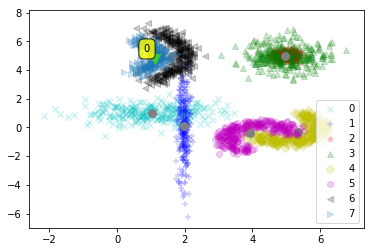

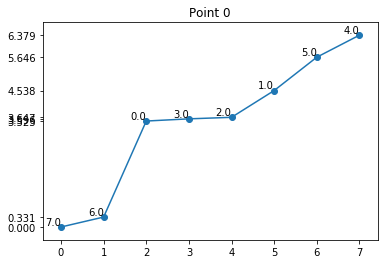

[[7 6]]


In [28]:
data = load_mat('data/synth8.mat')
c1, c2, c3, c4, c5 = data[:300], data[300:600], data[600:900], data[900:1200], data[1200:1500], 
c6, c7, c8 = data[1500:1800], data[1800:2100], data[2100:2400]

classes = np.array([[c1,'c','x'], [c2,'b','+'], [c3,'r','*'], [c4,'g','^'], [c5,'y','D'], 
           [c6,'m','o'], [c7,'k','<'], [c8,(31/255, 119/255, 180/255),'>']])

centroid1, centroid2, centroid3, centroid4 = np.mean(c1, axis=0)[:2], np.mean(c2, axis=0)[:2], np.mean(c3, axis=0)[:2], np.mean(c4, axis=0)[:2]
centroid5, centroid6, centroid7, centroid8 = np.mean(c5, axis=0)[:2], np.mean(c6, axis=0)[:2], np.mean(c7, axis=0)[:2], np.mean(c8, axis=0)[:2]

centroids = np.array([centroid1, centroid2, centroid3, centroid4, centroid5, centroid6, centroid7, centroid8])


plt.clf()
plt.cla()
plt.close()
for i, c in enumerate(classes):
    plt.scatter(c[0][0], c[0][1], c=c[1], marker=c[2], label=str(i), alpha=0.2)
    plt.scatter(centroids[i][0], centroids[i][1], c=(0.5,0.5,0.5), marker='o', s=60)
    
plt.legend(loc="lower right")


#test points

# p = np.array([[-1, 6, ]])
# p = np.array([[-1, 6]])
# p = np.array([[2, 0.5]])
# p = np.array([[3.5, 5.8]])
# p = np.array([[2.5, -5]])
# p_class = 1

# d1, d2, d3 = np.linalg.norm(p[0]-centroid1), np.linalg.norm(p[0]-centroid2), np.linalg.norm(p[0]-centroid3)
# d4, d5, d6 = np.linalg.norm(p[0]-centroid4), np.linalg.norm(p[0]-centroid5), np.linalg.norm(p[0]-centroid6)
# d7, d8 = np.linalg.norm(p[0]-centroid7), np.linalg.norm(p[0]-centroid8)

# dists = [[d1,0],[d2,1],[d3,2],[d4,3],[d5,4],[d6,5],[d7,6],[d8,7]]
# dists.sort()
# print(dists[:int(len(dists)/2)])
# chosen = np.asarray(dists[:int(len(dists)/2)])[:,1]
# print(chosen)


# plt.scatter(p[0,0], p[0,1], c=(0.2,0.8,0.2), marker='^', s=100)

# np.random.seed(1)


cols = list(data.columns)
Y = data[cols[-1]].copy()
cols.remove(cols[-1])
X = data[cols].copy()
roc_clf = ClassifierWithRoc(X,Y)
# print(roc_clf.c_groups, len(roc_clf.c_groups))
# pairs = [pair for pair in roc_clf.c_groups if pair[0] in chosen and pair[1] in chosen]
# clfs = [roc_clf.c_groups.index(clf) for clf in pairs]
# print(pairs, len(pairs))
# print(clfs)


x_train, x_val, x_test, y_train, y_val, y_test = roc_clf.split_data(X, Y)
scaler = roc_clf.z_score(x_train)
est = roc_clf.estimator(x_train, y_train, scaler)
fpr, tpr, thresholds, roc_auc, cutpoints = roc_clf.calculate_roc(est, x_val, x_train, y_val, 
                                                                 y_train, scaler)

x_test, y_test = np.asarray(x_test), np.asarray(y_test)
test_indexes = np.random.randint(len(x_test), size=1)
p_test = x_test[test_indexes]
c_test = y_test[test_indexes]

# p_test = x_test
# c_test = y_test

#calculate distances
distances = []
for i, pt in enumerate(p_test):
    plt.scatter(pt[0], pt[1], c=(0.2,0.8,0.2), marker='v', s=100)
    plt.annotate(str(i), xy=(pt[0], pt[1]), xytext=(-5, 5), 
                 textcoords='offset points', ha='right', va='bottom', bbox=dict(boxstyle='round,pad=0.5', 
                                                                                fc='yellow', alpha=0.8))
    dist = []
    for j, c in enumerate(centroids):
        d = np.linalg.norm(pt-c)
        dist.append([d, j])
    dist.sort()
    distances.append(dist)


plt.show()

distances = np.asarray(distances)

c_distances = []

for dist in distances:
    c_dist = []
    for i, d in enumerate(dist):
        if i == 0:
            c_dist.append([0.0, d[1]])
            continue
        else:
            c_dist.append([d[0]-dist[0,0], d[1]])
    c_distances.append(c_dist)

c_distances = np.asarray(c_distances)

influences = []
for i, dist in enumerate(c_distances):    
    std = np.std(dist[:,0])
    influences.append(list(dist[np.where(dist[:,0] < std)[0]][:,1].astype(np.int32)))
    plt.title("Point " + str(i))
#     print(dist)
    x_axis = np.arange(len(dist))
    plt.plot(x_axis, dist[:,0])
    plt.scatter(x_axis, dist[:,0])
    for j, d in enumerate(dist):
        plt.annotate(d[1], xy=(x_axis[j], d[0]), ha='right', va='bottom')
    plt.yticks(dist[:,0])
    plt.show()
    
influences = np.asarray(influences)
# print(c_test)

print(influences)
# influences = np.array([[0,1,6,7],[4,5], [4,5], [0,1,6,7], [3,4,5], [0,1,3,6,7], [3,6,7], [2,3], 
#                        [0,4,5], [2,3]])




#################### Point 0 ####################


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in double_scalars


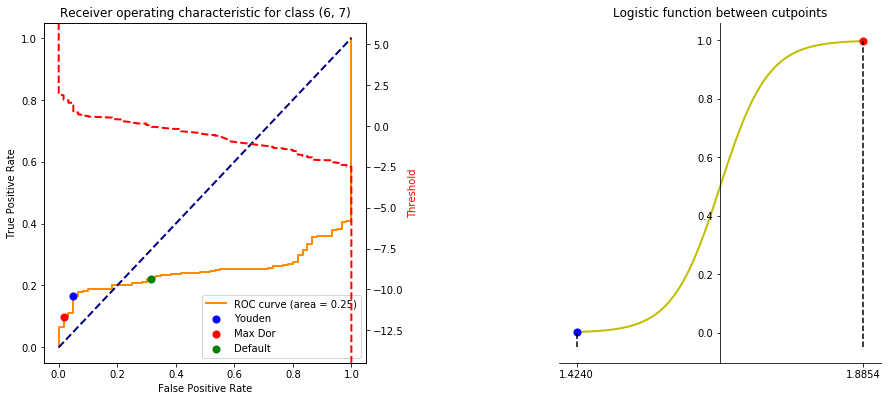

+-------+----------+---------+--------+---------+-----------+-----------+----------+---------------+
| point | original | default | youden | max dor | both zero | both half | both one | both logistic |
+-------+----------+---------+--------+---------+-----------+-----------+----------+---------------+
|   0   |   7.0    |   [7]   |  [6]   |   [6]   |    [6]    |    [6]    |   [6]    |      [6]      |
+-------+----------+---------+--------+---------+-----------+-----------+----------+---------------+
<table frame="box" rules="cols">
    <tr>
        <th style="padding-left: 1em; padding-right: 1em; text-align: center">point</th>
        <th style="padding-left: 1em; padding-right: 1em; text-align: center">original</th>
        <th style="padding-left: 1em; padding-right: 1em; text-align: center">default</th>
        <th style="padding-left: 1em; padding-right: 1em; text-align: center">youden</th>
        <th style="padding-left: 1em; padding-right: 1em; text-align: center">max dor</th>


In [29]:
t_1 = PrettyTable(['point', 'original', 'default', 'youden', 'max dor', 'both zero', 'both half', 'both one', 'both logistic'])

clf_pred = []; clf_pred_y = []; clf_pred_dor = []; clf_pred_zero = []; clf_pred_half = []; clf_pred_one = []; 
clf_pred_log = []

for i, inf in enumerate(influences):  
    pairs = [pair for pair in roc_clf.c_groups if pair[0] in inf and pair[1] in inf]
    clfs = [roc_clf.c_groups.index(clf) for clf in pairs]
    pred = roc_clf.predict(est, np.array([p_test[i]]), np.array([c_test[i]]), scaler, clfs=clfs)
    pred_y = roc_clf.predict(est, np.array([p_test[i]]), np.array([c_test[i]]), scaler, cutpoints, c=0, clfs=clfs)
    pred_dor = roc_clf.predict(est, np.array([p_test[i]]), np.array([c_test[i]]), scaler, cutpoints, c=1, clfs=clfs)
    pred_zero = roc_clf.predict(est, np.array([p_test[i]]), np.array([c_test[i]]), scaler, cutpoints, c=2, mode='zero', clfs=clfs)
    pred_half = roc_clf.predict(est, np.array([p_test[i]]), np.array([c_test[i]]), scaler, cutpoints, c=2, mode='half', clfs=clfs)
    pred_one = roc_clf.predict(est, np.array([p_test[i]]), np.array([c_test[i]]), scaler, cutpoints, c=2, mode='one', clfs=clfs)
    pred_log = roc_clf.predict(est, np.array([p_test[i]]), np.array([c_test[i]]), scaler, cutpoints, c=2, mode='logistic', clfs=clfs)


    clf_pred.append(pred[0]); clf_pred_y.append(pred_y[0]); clf_pred_dor.append(pred_dor[0]); clf_pred_zero.append(pred_zero[0]);
    clf_pred_half.append(pred_half[0]); clf_pred_one.append(pred_one[0]); clf_pred_log.append(pred_log[0]);

    t_1.add_row([i, c_test[i], pred[0], pred_y[0], pred_dor[0], pred_zero[0], pred_half[0], pred_one[0], pred_log[0]])    
    print(20*"#" + " Point " + str(i) + " " + 20*"#")
    roc_clf.plot_roc(fpr, tpr, thresholds, roc_auc, cutpoints, clfs=clfs)
print(t_1)
t_1.format = True
html = t_1.get_html_string()
print(html)

In [ ]:
plt.clf()
plt.cla()
plt.close()
# for j, p in enumerate(p_test):
#     plt.annotate('Point ' + str(j), xy=(p[0], p[1]), ha='left', va='top')
#     for i in influences[j]:
#         plt.plot([p[0], centroids[i,0]], [p[1], centroids[i,1]], '-o', color=classes[i,1])
#     plt.title("Influence graph for point " + str(j))
#     plt.xticks(np.arange(min(x_train[:,0]), max(x_train[:,0])))
#     plt.yticks(np.arange(min(x_train[:,1]), max(x_train[:,1])))
#     plt.show()

times = 10

acc_clf_pred = []; acc_clf_pred_y = []; acc_clf_pred_dor = []; acc_clf_pred_zero = []; acc_clf_pred_half = [];
acc_clf_pred_one = []; acc_clf_pred_log = []

acc_all_pred = []; acc_all_pred_y = []; acc_all_pred_dor = []; acc_all_pred_zero = []; acc_all_pred_half = [];
acc_all_pred_one = []; acc_all_pred_log = []

for t in tqdm(range(times)):
    x_train, x_val, x_test, y_train, y_val, y_test = roc_clf.split_data(X, Y)
    scaler = roc_clf.z_score(x_train)
    est = roc_clf.estimator(x_train, y_train, scaler)
    fpr, tpr, thresholds, roc_auc, cutpoints = roc_clf.calculate_roc(est, x_val, x_train, y_val, 
                                                                     y_train, scaler)

    x_test, y_test = np.asarray(x_test), np.asarray(y_test)
    test_indexes = np.random.randint(len(x_test), size=100)
    p_test = x_test[test_indexes]
    c_test = y_test[test_indexes]
    
    #calculate distances
    distances = []
    for i, pt in enumerate(p_test):
        dist = []
        for j, c in enumerate(centroids):
            d = np.linalg.norm(pt-c)
            dist.append([d, j])
        dist.sort()
        distances.append(dist)

    distances = np.asarray(distances)

    c_distances = []

    for dist in distances:
        c_dist = []
        for i, d in enumerate(dist):
            if i == 0:
                c_dist.append([0.0, d[1]])
                continue
            else:
                c_dist.append([d[0]-dist[0,0], d[1]])
        c_distances.append(c_dist)

    c_distances = np.asarray(c_distances)

    influences = []
    for i, dist in enumerate(c_distances):    
        std = np.std(dist[:,0])
        influences.append(list(dist[np.where(dist[:,0] < std)[0]][:,1].astype(np.int32)))

    influences = np.asarray(influences)
    
    t_1 = PrettyTable(['point', 'original', 'default', 'youden', 'max dor', 'both zero', 'both half', 'both one', 'both logistic'])

    clf_pred = []; clf_pred_y = []; clf_pred_dor = []; clf_pred_zero = []; clf_pred_half = []; clf_pred_one = []; 
    clf_pred_log = []

    for i, inf in enumerate(influences):  
        pairs = [pair for pair in roc_clf.c_groups if pair[0] in inf and pair[1] in inf]
        clfs = [roc_clf.c_groups.index(clf) for clf in pairs]
        pred = roc_clf.predict(est, np.array([p_test[i]]), np.array([c_test[i]]), scaler, clfs=clfs)
        pred_y = roc_clf.predict(est, np.array([p_test[i]]), np.array([c_test[i]]), scaler, cutpoints, c=0, clfs=clfs)
        pred_dor = roc_clf.predict(est, np.array([p_test[i]]), np.array([c_test[i]]), scaler, cutpoints, c=1, clfs=clfs)
        pred_zero = roc_clf.predict(est, np.array([p_test[i]]), np.array([c_test[i]]), scaler, cutpoints, c=2, mode='zero', clfs=clfs)
        pred_half = roc_clf.predict(est, np.array([p_test[i]]), np.array([c_test[i]]), scaler, cutpoints, c=2, mode='half', clfs=clfs)
        pred_one = roc_clf.predict(est, np.array([p_test[i]]), np.array([c_test[i]]), scaler, cutpoints, c=2, mode='one', clfs=clfs)
        pred_log = roc_clf.predict(est, np.array([p_test[i]]), np.array([c_test[i]]), scaler, cutpoints, c=2, mode='logistic', clfs=clfs)


        clf_pred.append(pred[0]); clf_pred_y.append(pred_y[0]); clf_pred_dor.append(pred_dor[0]); clf_pred_zero.append(pred_zero[0]);
        clf_pred_half.append(pred_half[0]); clf_pred_one.append(pred_one[0]); clf_pred_log.append(pred_log[0]);

        t_1.add_row([i, c_test[i], pred[0], pred_y[0], pred_dor[0], pred_zero[0], pred_half[0], pred_one[0], pred_log[0]])    
    #     print(20*"#" + " Point " + str(i) + " " + 20*"#")
    #     roc_clf.plot_roc(fpr, tpr, thresholds, roc_auc, cutpoints, clfs=clfs)
    # print(t_1)

    t_2 = PrettyTable(['point', 'original', 'default', 'youden', 'max dor', 'both zero', 'both half', 'both one', 'both logistic'])

    all_pred = []; all_pred_y = []; all_pred_dor = []; all_pred_zero = []; all_pred_half = []; all_pred_one = []; 
    all_pred_log = []

    for i, p in enumerate(p_test):
        pred = roc_clf.predict(est, np.array([p]), np.array([c_test[i]]), scaler)
        pred_y = roc_clf.predict(est, np.array([p]), np.array([c_test[i]]), scaler, cutpoints, c=0)
        pred_dor = roc_clf.predict(est, np.array([p]), np.array([c_test[i]]), scaler, cutpoints, c=1)
        pred_zero = roc_clf.predict(est, np.array([p]), np.array([c_test[i]]), scaler, cutpoints, c=2, mode='zero')
        pred_half = roc_clf.predict(est, np.array([p]), np.array([c_test[i]]), scaler, cutpoints, c=2, mode='half')
        pred_one = roc_clf.predict(est, np.array([p]), np.array([c_test[i]]), scaler, cutpoints, c=2, mode='one')
        pred_log = roc_clf.predict(est, np.array([p]), np.array([c_test[i]]), scaler, cutpoints, c=2, mode='logistic')


        all_pred.append(pred[0]); all_pred_y.append(pred_y[0]); all_pred_dor.append(pred_dor[0]); all_pred_zero.append(pred_zero[0]);
        all_pred_half.append(pred_half[0]); all_pred_one.append(pred_one[0]); all_pred_log.append(pred_log[0]);

        t_2.add_row([i, c_test[i], pred[0], pred_y[0], pred_dor[0], pred_zero[0], pred_half[0], pred_one[0], pred_log[0]])   
    
    
    acc_clf_pred.append(accuracy_score(c_test, clf_pred)); acc_clf_pred_y.append(accuracy_score(c_test, clf_pred_y)); 
    acc_clf_pred_dor.append(accuracy_score(c_test, clf_pred_dor)); acc_clf_pred_zero.append(accuracy_score(c_test, clf_pred_zero)); 
    acc_clf_pred_half.append(accuracy_score(c_test, clf_pred_half)); acc_clf_pred_one.append(accuracy_score(c_test, clf_pred_one)); 
    acc_clf_pred_log.append(accuracy_score(c_test, clf_pred_log))
    
    acc_all_pred.append(accuracy_score(c_test, all_pred)); acc_all_pred_y.append(accuracy_score(c_test, all_pred_y)); 
    acc_all_pred_dor.append(accuracy_score(c_test, all_pred_dor)); acc_all_pred_zero.append(accuracy_score(c_test, all_pred_zero)); 
    acc_all_pred_half.append(accuracy_score(c_test, all_pred_half)); acc_all_pred_one.append(accuracy_score(c_test, all_pred_one)); 
    acc_all_pred_log.append(accuracy_score(c_test, all_pred_log))
                                                                                            
t_3 = PrettyTable()
t_3.add_column('With all clf mean', [np.mean(acc_all_pred), np.mean(acc_all_pred_y),
                                     np.mean(acc_all_pred_dor), np.mean(acc_all_pred_zero), 
                                     np.mean(acc_all_pred_half), np.mean(acc_all_pred_one),
                                     np.mean(acc_all_pred_log)])
                                                                                            
t_3.add_column('With all clf std', [np.std(acc_all_pred), np.std(acc_all_pred_y),
                                    np.std(acc_all_pred_dor), np.std(acc_all_pred_zero), 
                                    np.std(acc_all_pred_half), np.std(acc_all_pred_one),
                                    np.std(acc_all_pred_log)])

t_3.add_column('With filtered clf mean', [np.mean(acc_clf_pred), np.mean(acc_clf_pred_y),
                                          np.mean(acc_clf_pred_dor), np.mean(acc_clf_pred_zero), 
                                          np.mean(acc_clf_pred_half), np.mean(acc_clf_pred_one),
                                          np.mean(acc_clf_pred_log)])

t_3.add_column('With filtered clf std', [np.std(acc_clf_pred), np.std(acc_clf_pred_y),
                                         np.std(acc_clf_pred_dor), np.std(acc_clf_pred_zero), 
                                         np.std(acc_clf_pred_half), np.std(acc_clf_pred_one),
                                         np.std(acc_clf_pred_log)])

# print(t_2)

print(t_3)

In [ ]:
datasets = [heart_data(), load_car(), wine_quality_red(), wine_quality_white(), load_abalone(), 
            load_mat('data/synth8.mat'), load_mat('data/synth8_unbalanced.mat')]

cols = ['dataset', 'mean acc', 'std', 'mean acc yoden', 'std yoden', 'mean acc max dor', 'std max dor',
        'mean acc both zero', 'std both zero', 'mean acc both half', 'std both half',
        'mean acc both one', 'std both one', 'mean acc both logistic', 'std both logistic']
names = [['heart'], ['car'], ['red wine quality'], ['white wine quality'], ['abalone'], ['synth8'],
         ['unbalanced synth8']]

d_rows = []

times = 10
for d in datasets:
    d_rows.append(apply(d, times).ravel())
d_rows = np.asarray(d_rows)
d_rows = np.concatenate((names, d_rows), axis=1)
df = pd.DataFrame(data=np.asarray(d_rows), columns=cols)
df
# data = heart_data()
# data = load_adult()
# data = wine_quality_red()
# data = wine_quality_white()
# data = load_abalone()
# data = load_mat('data/synth8.mat')
# data = load_mat('data/synth8_unbalanced.mat')

# data = heart_data()
# apply(data).ravel()

In [ ]:
datasets = [heart_data(), load_car(), wine_quality_red(), wine_quality_white(), load_abalone(), 
            load_mat('data/synth8.mat'), load_mat('data/synth8_unbalanced.mat')]

cols = ['dataset', 'mean acc', 'std', 'mean acc yoden', 'std yoden', 'mean acc max dor', 'std max dor',
        'mean acc both zero', 'std both zero', 'mean acc both half', 'std both half',
        'mean acc both one', 'std both one', 'mean acc both logistic', 'std both logistic']
names = [['heart'], ['car'], ['red wine quality'], ['white wine quality'], ['abalone'], ['synth8'],
         ['unbalanced synth8']]

d_rows = []

times = 10
for d in datasets:
    d_rows.append(apply(d, times).ravel())
d_rows = np.asarray(d_rows)
d_rows = np.concatenate((names, d_rows), axis=1)
df = pd.DataFrame(data=np.asarray(d_rows), columns=cols)
df

In [ ]:
pd.set_option('precision', 2)
cat_columns = df.select_dtypes(['object']).columns
for c in cat_columns:
    try:
        df[c] = df[c].astype('float64')
    except ValueError:
        pass

In [ ]:
df